Description

Problem statement

End Result

In [1922]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import json
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.style.use('fivethirtyeight')

In [1923]:
if os.path.isfile('loan.csv'):
    print("loading from csv")
    loans = pd.read_csv('loan.csv', low_memory=False, encoding='iso-8859-1')
else:
    print("loading from zip")
    loans = pd.read_csv('loan.zip',
                        compression='zip',
                        low_memory=False,
                        encoding='iso-8859-1')

loans.info()

loading from zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


Getting basic info about the data

In [1924]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
id                                int64
member_id                         int64
loan_amnt                         int64
funded_amnt                       int64
funded_amnt_inv                   float64
term                              object
int_rate                          object
installment                       float64
grade                             object
sub_grade                         object
emp_title                         object
emp_length                        object
home_ownership                    object
annual_inc                        float64
verification_status               object
issue_d                           object
loan_status                       object
pymnt_plan                        object
url                               object
desc                              object
purpose                           object
title                         

Showing the counts of entries per column

In [1925]:
loans.count()

id                            39717
member_id                     39717
loan_amnt                     39717
funded_amnt                   39717
funded_amnt_inv               39717
                              ...  
tax_liens                     39678
tot_hi_cred_lim                   0
total_bal_ex_mort                 0
total_bc_limit                    0
total_il_high_credit_limit        0
Length: 111, dtype: int64

In [1926]:
num_rows = loans.shape[0]
num_missing = num_rows - loans.count()
print(num_missing)

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64


In [1927]:
loans.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

### Finding columns which have NAN

In [1928]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*(df[c].isnull().sum()/len(df[c].index)), 2)
            } for c in df.columns if round(100*(df[c].isnull().sum()/len(df[c].index)), 2)>0]
    return pd.DataFrame.from_records(nan_cols)

In [1929]:
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,desc,32.5800
3,title,0.0300
4,mths_since_last_delinq,64.6600
...,...,...
63,tax_liens,0.1000
64,tot_hi_cred_lim,100.0000
65,total_bal_ex_mort,100.0000
66,total_bc_limit,100.0000


#### Deleting columns which have 100% NAN

In [1930]:
loans = loans.dropna(how='all', axis=1)
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,desc,32.5800
3,title,0.0300
4,mths_since_last_delinq,64.6600
5,mths_since_last_record,92.9900
6,revol_util,0.1300
7,last_pymnt_d,0.1800
8,next_pymnt_d,97.1300
9,last_credit_pull_d,0.0100


#### Deleting columns with more than 90% empty values

In [1931]:
loans = loans.drop(['next_pymnt_d', 'mths_since_last_record'], axis=1)
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,desc,32.5800
3,title,0.0300
4,mths_since_last_delinq,64.6600
5,revol_util,0.1300
6,last_pymnt_d,0.1800
7,last_credit_pull_d,0.0100
8,collections_12_mths_ex_med,0.1400
9,chargeoff_within_12_mths,0.1400


#### Deleting not useful columns like `desc`

In [1932]:
loans = loans.drop(['desc'], axis=1)
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,title,0.0300
3,mths_since_last_delinq,64.6600
4,revol_util,0.1300
5,last_pymnt_d,0.1800
6,last_credit_pull_d,0.0100
7,collections_12_mths_ex_med,0.1400
8,chargeoff_within_12_mths,0.1400
9,pub_rec_bankruptcies,1.7500


#### Deleting rows where `revol_util`, `last_pymnt_d`,`last_credit_pull_d`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` or `tax_liens` is NAN

In [1933]:
loans = loans[~loans['revol_util'].isnull()]
loans = loans[~loans['last_pymnt_d'].isnull()]
loans = loans[~loans['last_credit_pull_d'].isnull()]
loans = loans[~loans['collections_12_mths_ex_med'].isnull()]
loans = loans[~loans['chargeoff_within_12_mths'].isnull()]
loans = loans[~loans['pub_rec_bankruptcies'].isnull()]
loans = loans[~loans['tax_liens'].isnull()]

get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1800
1,emp_length,2.7400
2,title,0.0300
3,mths_since_last_delinq,65.7900


In [1934]:
loans = loans.drop(['emp_title', 'url'], axis=1)

In [1935]:
loans['emp_length'].value_counts()

10+ years    8750
< 1 year     4397
2 years      4291
3 years      4023
4 years      3377
5 years      3235
1 year       3133
6 years      2193
7 years      1747
8 years      1449
9 years      1238
Name: emp_length, dtype: int64

`emp_length` is a ordinal categorical variable, however only 2.74% rows does not have this column, we can drop such rows as even after this we will have a descent data size

In [1936]:
loans = loans[~loans['emp_length'].isnull()]
get_columns_with_nan_percentage(loans)

,column,percentage
0,title,0.0300
1,mths_since_last_delinq,65.7400


Dropping `mths_since_last_delinq` as **~65%** are NAN 

In [1937]:
loans = loans.drop(['mths_since_last_delinq'], axis=1)

In [1938]:
loans['title'].nunique()

18675

We can delete `member_id`, `id`, `title` and `zip_code` as they will not help in the analysis

In [1939]:
loans = loans.drop(['id', 'member_id', 'title', 'zip_code'], axis=1)

Find columns with less than 1 unique values

In [1940]:
loans.columns[loans.nunique() <= 1]

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [1941]:
loans = loans.drop(loans.columns[loans.apply(lambda col:(len(col.unique())<=1))], axis=1)

### Deleting all rows where the status is `current`

In [1942]:
loans = loans[~(loans['loan_status'] == 'Current')]
loans['loan_defaulted'] = loans['loan_status'].apply(
    lambda x: 1 if x == 'Charged Off' else 0)

### As we have deleted all the *current* loans, we can drop column `out_prncp` and `out_prncp_inv` since they have only **0**

In [1943]:
loans = loans.drop(['out_prncp', 'out_prncp_inv'], axis=1)

Deleting `pub_rec`, `last_credit_pull_d`, `last_pymnt_amnt`, `last_pymnt_d` and `earliest_cr_line` as they will not provide any insight in the defaulter pattern

In [1944]:
loans = loans.drop(['pub_rec', 'last_credit_pull_d',
                    'last_pymnt_amnt', 'last_pymnt_d','earliest_cr_line'], axis=1)

In [1945]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36735 entries, 0 to 39623
Data columns (total 32 columns):
loan_amnt                  36735 non-null int64
funded_amnt                36735 non-null int64
funded_amnt_inv            36735 non-null float64
term                       36735 non-null object
int_rate                   36735 non-null object
installment                36735 non-null float64
grade                      36735 non-null object
sub_grade                  36735 non-null object
emp_length                 36735 non-null object
home_ownership             36735 non-null object
annual_inc                 36735 non-null float64
verification_status        36735 non-null object
issue_d                    36735 non-null object
loan_status                36735 non-null object
purpose                    36735 non-null object
addr_state                 36735 non-null object
dti                        36735 non-null float64
delinq_2yrs                36735 non-null int64
inq_last

####  'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', `total_acc` are behavior related attributes and thus can be dropped.

In [1946]:
loans = loans.drop(['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','total_acc'], axis=1)

In [1947]:
def segregate_columns(df=loans):
    segregation = [{ 
                    "col":c,
                    "c_type": 'continuous' if df[c].nunique()>15 else 'categorical',
                    "unique_count":df[c].nunique()
                   } for c in df.columns ]
    
    return pd.DataFrame.from_records(segregation)

### We will now segregate all the variables as **continuous** or **categorical**

In [1948]:
loans_columns = segregate_columns()
loans_columns

,col,c_type,unique_count
0,loan_amnt,continuous,855
1,funded_amnt,continuous,1009
2,funded_amnt_inv,continuous,7594
3,term,categorical,2
4,int_rate,continuous,335
5,installment,continuous,14367
6,grade,categorical,7
7,sub_grade,continuous,35
8,emp_length,categorical,11
9,home_ownership,categorical,4


### We have treated any variable having more than 15 unique values as continuous. However, after the analyzing the data and applying domain/business knowledge we will treat `sub_grade` and `addr_state` as `categorical`

In [1949]:
loans_columns.loc[loans_columns['col'] == 'addr_state', 'c_type'] = 'categorical'
loans_columns.loc[loans_columns['col'] == 'sub_grade', 'c_type'] = 'categorical'
loans_columns

,col,c_type,unique_count
0,loan_amnt,continuous,855
1,funded_amnt,continuous,1009
2,funded_amnt_inv,continuous,7594
3,term,categorical,2
4,int_rate,continuous,335
5,installment,continuous,14367
6,grade,categorical,7
7,sub_grade,categorical,35
8,emp_length,categorical,11
9,home_ownership,categorical,4


### Segregation of the variables




#### Continuous variables

In [1950]:
def get_columns_for_type(t):
    return loans_columns[loans_columns['c_type']==t]['col'].tolist()

In [1951]:
print(get_columns_for_type('continuous'))

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'issue_d', 'dti', 'open_acc', 'revol_bal', 'revol_util']


#### Categorical variables

In [1952]:
print(get_columns_for_type('categorical'))

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec_bankruptcies', 'loan_defaulted']


# Univariate Analysis

Reference for the following methods: https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#89dd

In [1953]:
default_figsize = (12, 5)

In [1954]:
def categorical_summarized(dataframe,
                           x=None,
                           y=None,
                           hue=None,
                           palette='Set1',
                           verbose=True,
                           figsize=default_figsize,
                           title="",
                           xlabel=None,
                           ylabel=None,
                           rotate_labels=False):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]

    if verbose:
        print(series.describe())
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())

    sns.set(rc={'figure.figsize': figsize})
    sorted_df = dataframe.sort_values(column_interested)
    ax = sns.countplot(x=x, y=y, hue=hue, data=sorted_df)

    plt.title(title)
    if not xlabel:
        xlabel = column_interested
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    total = len(dataframe[column_interested])
    if rotate_labels:
        plt.setp(ax.get_xticklabels(),
                 rotation=30,
                 horizontalalignment='right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
    plt.tight_layout()
    plt.show()

In [1955]:
def quantitative_summarized(dataframe,
                            x=None,
                            y=None,
                            hue=None,
                            palette='Set1',
                            ax=None,
                            verbose=True,
                            swarm=False,
                            figsize=default_figsize):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    if verbose:
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())
    sns.set(rc={'figure.figsize': figsize})

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x,
                      y=y,
                      hue=hue,
                      data=dataframe,
                      palette=palette,
                      ax=ax)
    plt.tight_layout()
    plt.show()

In [1956]:
def plot_column(df,
                col,
                chart_type='Hist',
                dtype=int,
                bins=25,
                figsize=default_figsize):
    temp_df = df[col]
    sns.set(rc={'figure.figsize': figsize})
    if chart_type == 'Hist':
        ax = sns.countplot(temp_df)
    elif chart_type == 'Dens':
        ax = sns.distplot(temp_df)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.round(np.linspace(xmin, xmax, bins), 2))
    plt.tight_layout()
    plt.locator_params(axis='y', nbins=6)
    plt.show()

In [1957]:
def univariate_analysis(col,
                        chart_type='Dens',
                        df=loans,
                        is_categorical=False,
                        title="",
                        xlabel=None,
                        ylabel=None,
                        rotate_labels=False,
                        bins=25):
    if is_categorical:
        categorical_summarized(df,
                               x=col,
                               title=title,
                               xlabel=xlabel,
                               ylabel=ylabel,
                               rotate_labels=rotate_labels,
                               verbose=False)
    else:
        quantitative_summarized(df, y=col, verbose=False)
        plot_column(df, col, chart_type=chart_type, bins=bins)

### Categorical variables

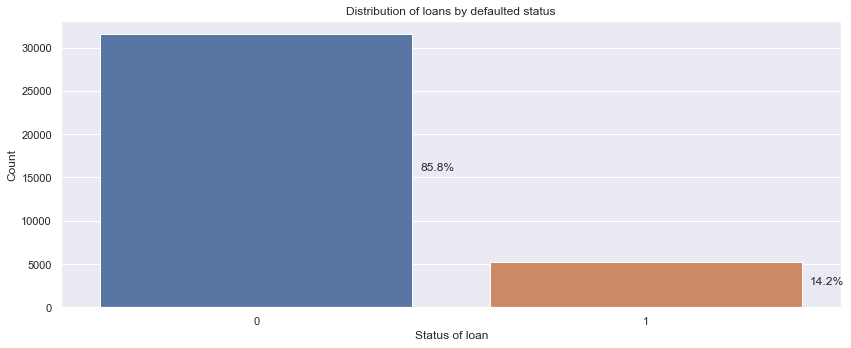

In [1958]:
univariate_analysis('loan_defaulted',
                    is_categorical=True,
                    title="Distribution of loans by defaulted status",
                    xlabel="Status of loan",
                    ylabel="Count")

#### We can see that almost 14% loans defaulted.

In [1959]:
loans['term'].value_counts()

 36 months    27496
 60 months     9239
Name: term, dtype: int64

In [1960]:
loans['term'] = loans['term'].str.strip()

As we can see `term` has two values. `term` is a ordinal categorical variable. We can create a new column `is_short_term` which will have *1* for `36 months` and *0* for `60 months`

In [1961]:
loans['is_short_term'] = loans['term'].apply(lambda x : 1 if x == '36 months' else 0)

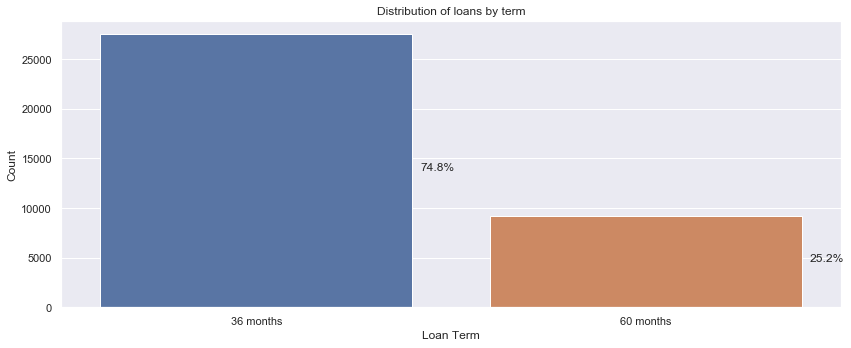

In [1962]:
univariate_analysis('term',
                    is_categorical=True,
                    title="Distribution of loans by term",
                    xlabel="Loan Term",
                    ylabel="Count")

From the plot, we can see that short term loans (36 months) are the most given loans

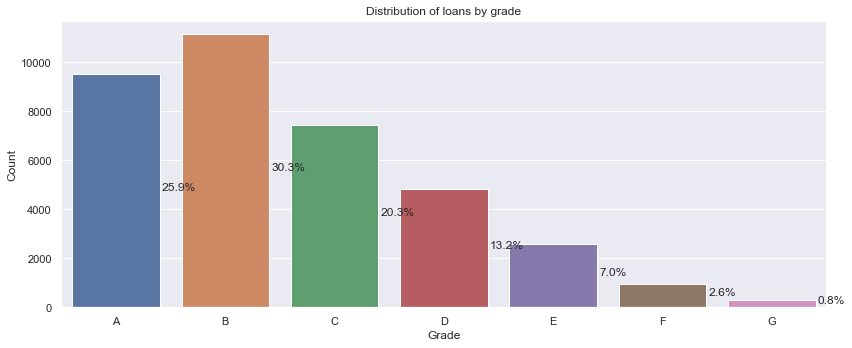

In [1963]:
univariate_analysis('grade',
                    is_categorical=True,
                    title="Distribution of loans by grade",
                    xlabel="Grade",
                    ylabel="Count")

We can see that type B grade loans are the most given loans. We can also see that the loans are given based on grades.

We are not doing univariate analysis of sub grades as we already did analysis on the grades. We will do multi variate analysis for sub grades based on grades against the defaulted loans.

In [1964]:
loans['emp_length'].value_counts()

10+ years    8359
< 1 year     4322
2 years      4194
3 years      3940
4 years      3283
5 years      3147
1 year       3062
6 years      2132
7 years      1685
8 years      1405
9 years      1206
Name: emp_length, dtype: int64

As we can, `emp_length` has 11 distinct values, this can be treated as ordinal categorical variable

In [1965]:
loans['emp_length'] = loans['emp_length'].apply(
    lambda x: x.replace(' years', "").replace(' year', "").replace(
        "+", "").replace("< 1", "0")).astype(int)

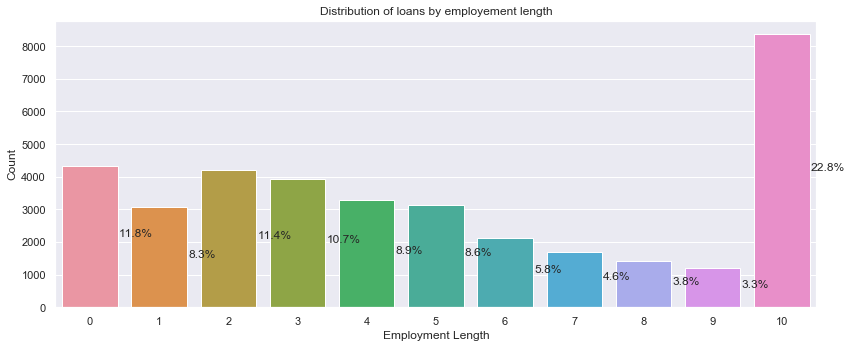

In [1966]:
univariate_analysis('emp_length',
                    is_categorical=True,
                    title="Distribution of loans by employement length",
                    xlabel="Employment Length",
                    ylabel="Count")

We can see the people having experience more that 10 are the ones availing the most loans

However, we can get more insight, if we create a new variable based on `emp_length` which has values like `junior`, `mid-level` and `senior`

In [1967]:
add_categorical_column(loans, ['junior', 'mid-level', 'senior'], 'emp_length',
                       'emp_exp', [0, 4, 8])

   emp_length emp_exp
0          10  senior
1           0  junior
2          10  senior
3          10  senior
5           3  junior


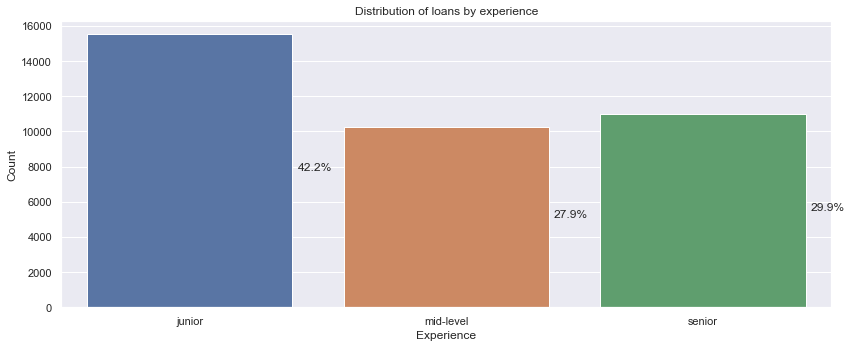

In [1968]:
univariate_analysis('emp_exp',
                    is_categorical=True,
                    title="Distribution of loans by experience",
                    xlabel="Experience",
                    ylabel="Count")

We can say on a higher level that junior level employees have taken more loans.

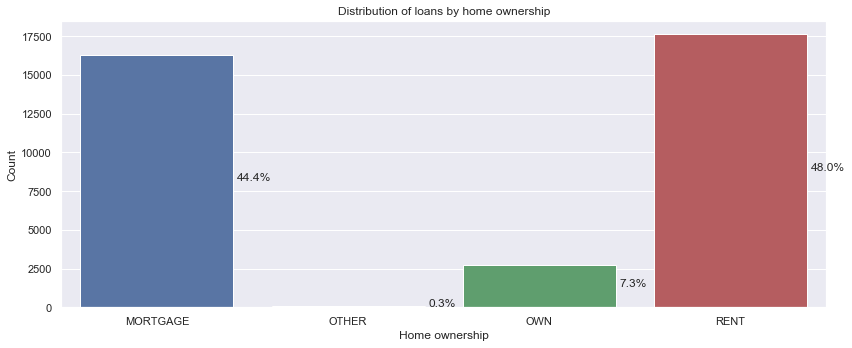

In [1969]:
univariate_analysis('home_ownership',
                    is_categorical=True,
                    title="Distribution of loans by home ownership",
                    xlabel="Home ownership",
                    ylabel="Count")

People with rented house have opted for the most loans

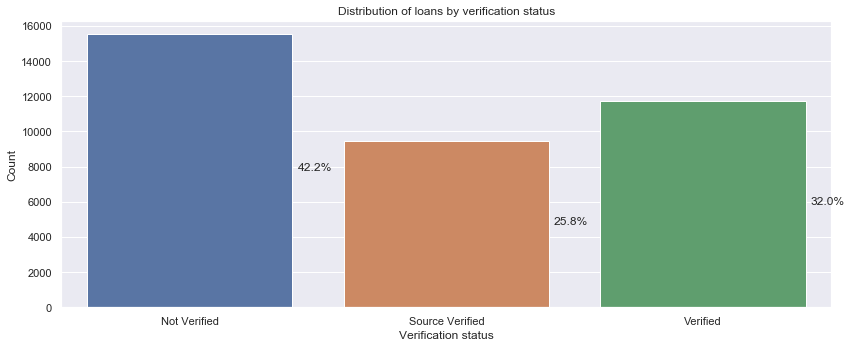

In [1970]:
univariate_analysis('verification_status',
                    is_categorical=True,
                    title="Distribution of loans by verification status",
                    xlabel="Verification status",
                    ylabel="Count")

We can see that most loans are given without any verification.

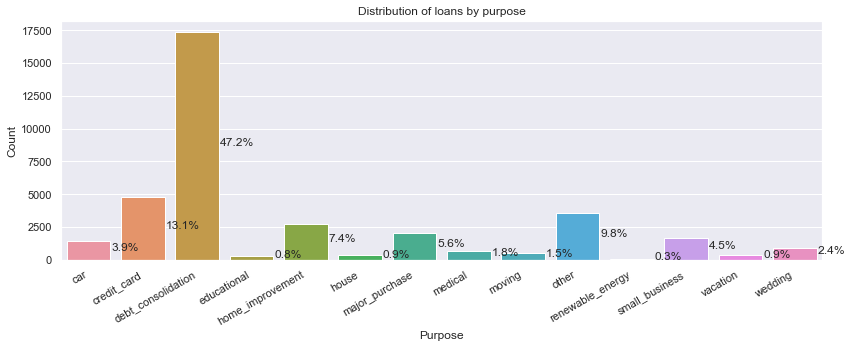

In [1971]:
univariate_analysis('purpose',
                    is_categorical=True,
                    title="Distribution of loans by purpose",
                    xlabel="Purpose",
                    ylabel="Count",
                    rotate_labels=True)

We can see most loans are for `debt consolidation` followed by `credit card`.

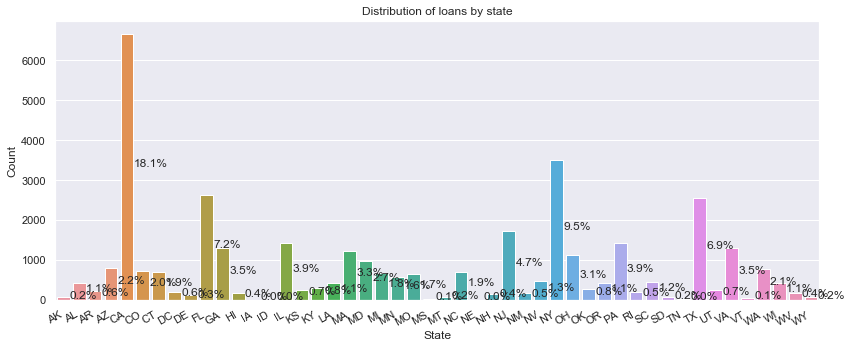

In [1972]:
univariate_analysis('addr_state',
                    is_categorical=True,
                    title="Distribution of loans by state",
                    xlabel="State",
                    ylabel="Count",
                    rotate_labels=True)

##### We can see most loans are taken in California (CA) followed by New York (NY)

#### We will do bivariate analysis on `delinq_2yrs`, `inq_last_6mths`, `pub_rec_bankruptcies` with the `loan_status`.

### Continuous variables

In [1973]:
loans_continuous = loans[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'issue_d', 'dti', 'open_acc', 'revol_bal', 'revol_util']]
loans_continuous.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,open_acc,revol_bal
count,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000
mean,11153.4531,10884.2317,10444.7007,324.9947,69468.9407,13.3371,9.3058,13384.8863
std,7368.3826,7107.2998,7008.0288,208.8390,64063.8854,6.6496,4.3760,15856.3133
min,500.0000,500.0000,0.0000,16.0800,4000.0000,0.0000,2.0000,0.0000
25%,5500.0000,5425.0000,5000.0000,167.7300,41200.0000,8.2200,6.0000,3734.5000
50%,10000.0000,9600.0000,9000.0000,280.2800,60000.0000,13.4300,9.0000,8880.0000
75%,15000.0000,15000.0000,14353.3263,429.4500,83000.0000,18.5900,12.0000,17035.5000
max,35000.0000,35000.0000,35000.0000,1305.1900,6000000.0000,29.9900,44.0000,149588.0000


count   36735.0000
mean    11153.4531
std      7368.3826
min       500.0000
25%      5500.0000
50%     10000.0000
75%     15000.0000
max     35000.0000
Name: loan_amnt, dtype: float64


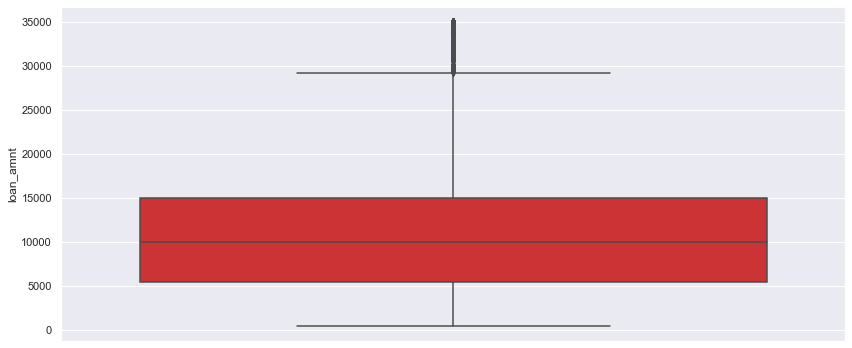

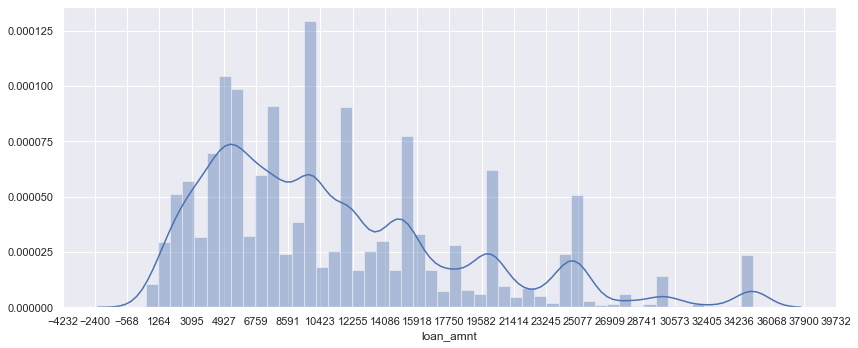

In [1974]:
univariate_analysis('loan_amnt')

As we can see there are some outliers in the `loan_amnt`. However, we can't remove these as they may be the defaulted one. We can create a new categorical column `loan_amnt_type` which categorizes the loans as **low, medium and high**

In [1975]:
def add_categorical_column(df,
                           bins,
                           column,
                           new_column,
                           interval,
                           verbose=False):
    interval.append(df[column].max() + 1)
    df[new_column] = pd.cut(df[column], interval, right=False, labels=bins)
    if verbose:
        print(df[[column, new_column]].head())

In [1976]:
add_categorical_column(loans, ['low', 'medium', 'high'], 'loan_amnt',
                       'loan_amnt_type', [0, 5000, 15000])

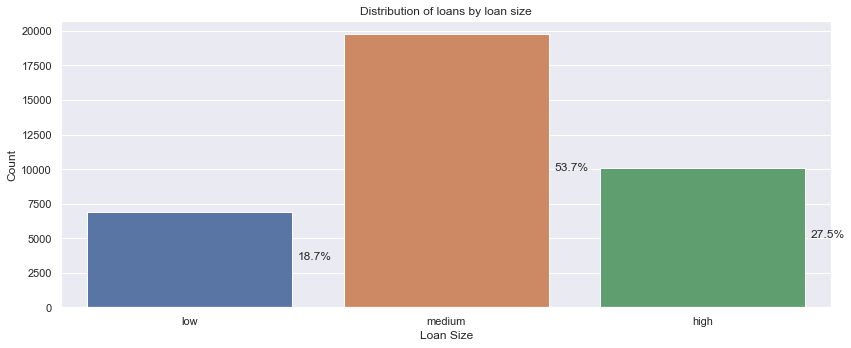

In [1977]:
univariate_analysis('loan_amnt_type',
                    is_categorical=True,
                    title="Distribution of loans by loan size",
                    xlabel="Loan Size",
                    ylabel="Count",
                    rotate_labels=False)

### From this, we can infer that `medium` type loans are the most given loans by Lending club

count   36735.0000
mean    10884.2317
std      7107.2998
min       500.0000
25%      5425.0000
50%      9600.0000
75%     15000.0000
max     35000.0000
Name: funded_amnt, dtype: float64


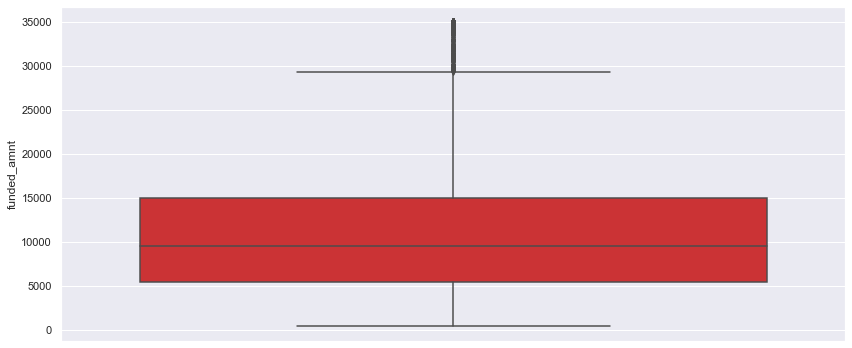

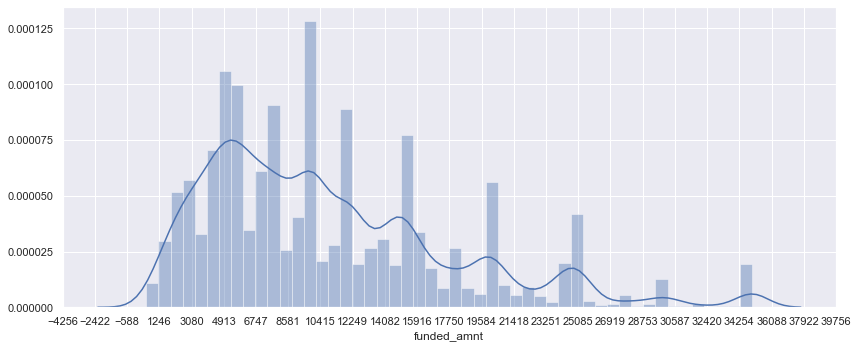

In [1978]:
univariate_analysis('funded_amnt')

As we can see there are some outliers in the `funded_amnt`. However, we can't remove these as they may be the defaulted one. We can create a new categorical column `funded_amnt_type` which categorizes the loans as **low, medium and high**

In [1979]:
add_categorical_column(loans, ['low', 'medium', 'high'], 'funded_amnt',
                       'funded_amnt_type', [0, 5000, 15000])

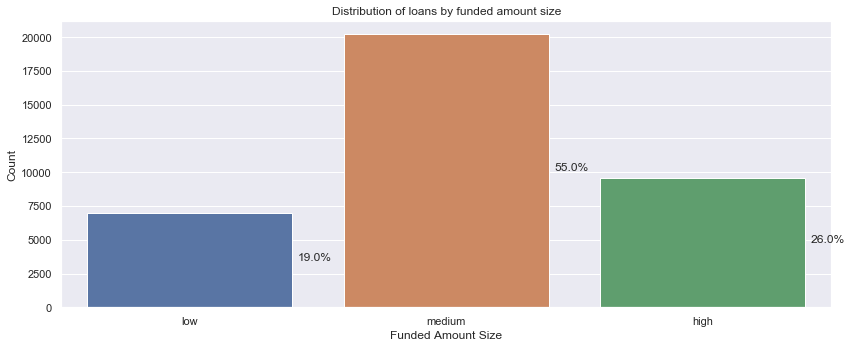

In [1980]:
univariate_analysis('funded_amnt_type',
                    is_categorical=True,
                    title="Distribution of loans by funded amount size",
                    xlabel="Funded Amount Size",
                    ylabel="Count",
                    rotate_labels=False)

The plot shows that the medium funded loans are the most in the count

count   36735.0000
mean    10444.7007
std      7008.0288
min         0.0000
25%      5000.0000
50%      9000.0000
75%     14353.3263
max     35000.0000
Name: funded_amnt_inv, dtype: float64


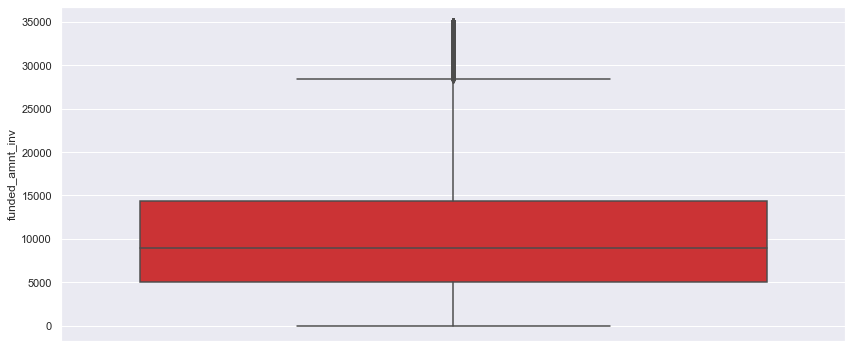

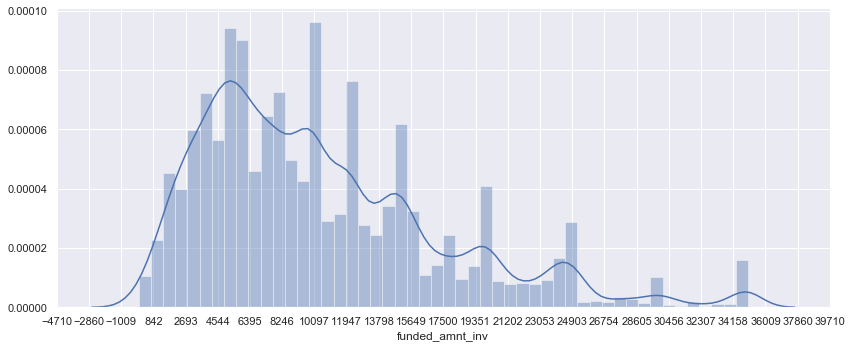

In [1981]:
univariate_analysis('funded_amnt_inv')

As we can see there are some outliers in the `funded_amnt_inv`. However, we can't remove these as they may be the defaulted one. We can create a new categorical column `funded_amnt_inv_type` which categorizes the loans as **low, medium and high**

In [1982]:
add_categorical_column(loans, ['low', 'medium', 'high'], 'funded_amnt_inv',
                       'funded_amnt_inv_type', [0, 5000, 15000])

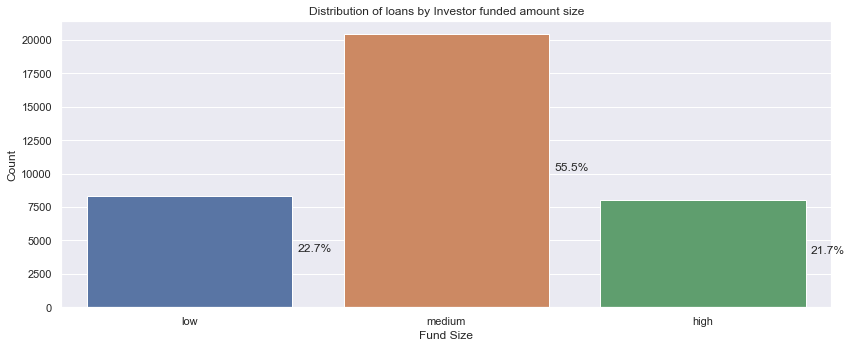

In [1983]:
univariate_analysis('funded_amnt_inv_type', is_categorical=True,
                    title="Distribution of loans by Investor funded amount size",
                    xlabel="Fund Size",
                    ylabel="Count",
                    rotate_labels=False)

The plot shows that the investors have funded the `medium` type loans the most.

In [1984]:
loans['int_rate'] = loans['int_rate'].str.replace('%',"").astype(float)

count   36735.0000
mean       11.9805
std         3.7012
min         5.4200
25%         8.9400
50%        11.8300
75%        14.4600
max        24.4000
Name: int_rate, dtype: float64


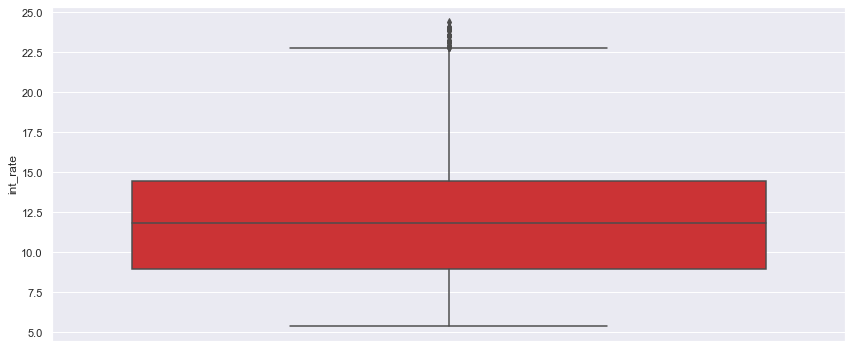

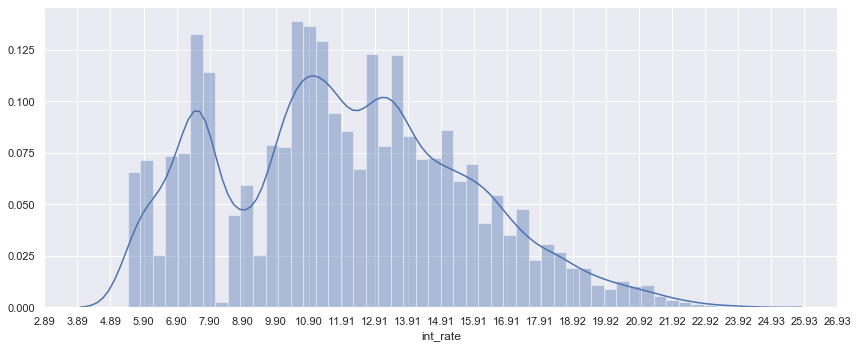

In [1985]:
univariate_analysis('int_rate')

In [1986]:
add_categorical_column(loans,
                       ['very-low', 'low', 'medium', 'high', 'very-high'],
                       'int_rate', 'int_rate_slab',
                       [0.0, 6.0, 10.0, 14.0, 18.0])

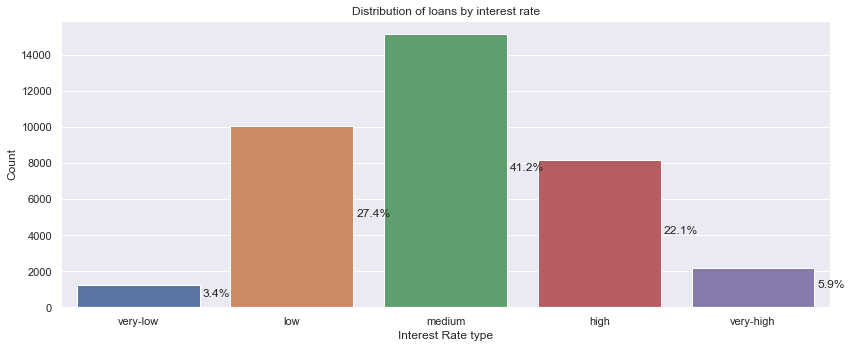

In [1987]:
univariate_analysis('int_rate_slab', is_categorical=True,
                    title="Distribution of loans by interest rate",
                    xlabel="Interest Rate type",
                    ylabel="Count",
                    rotate_labels=False)

### As we can see that the most loan have interest range between `10.0` to `14.0`

count     36735.0000
mean      69468.9407
std       64063.8854
min        4000.0000
25%       41200.0000
50%       60000.0000
75%       83000.0000
max     6000000.0000
Name: annual_inc, dtype: float64


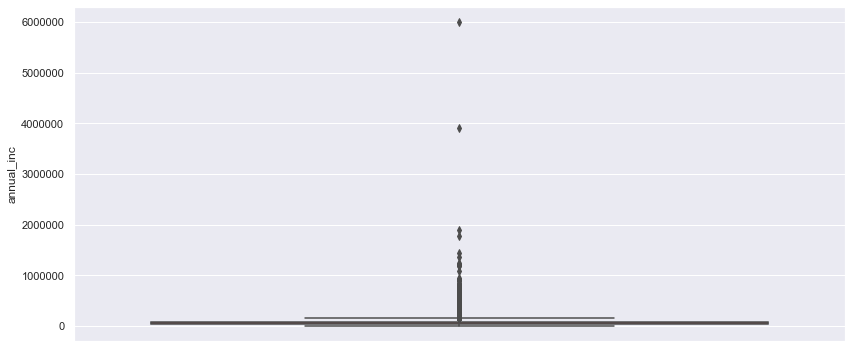

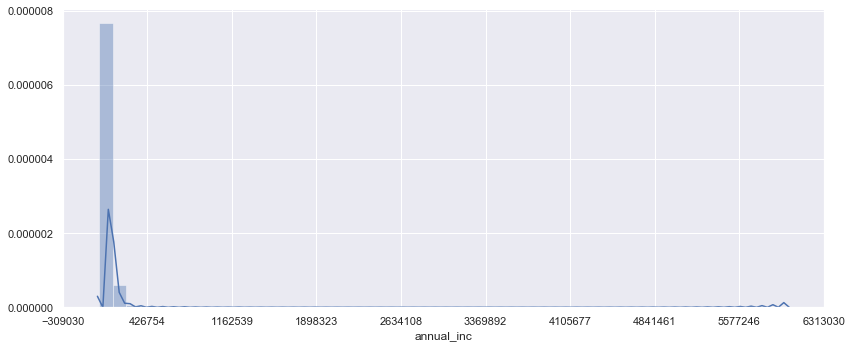

In [1988]:
univariate_analysis('annual_inc',bins=10)

As we can see there are some outliers in the `annual_inc`. However, we can't remove these as they may be the defaulted one. We can create a new categorical column `income_category` which categorizes the annual income as **low, middle, upper-middle and rich**

In [1989]:
add_categorical_column(loans, ['low', 'middle', 'upper-middle', 'rich'],
                       'annual_inc', 'income_category',
                       [0.0, 30000.0, 80000.0, 150000.0])

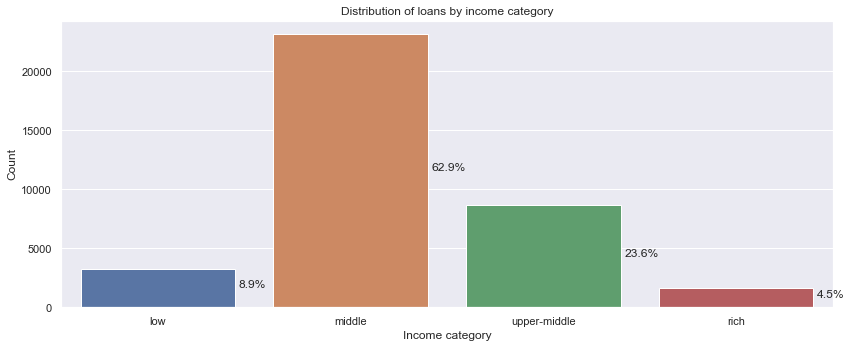

In [1990]:
univariate_analysis('income_category', is_categorical=True,
                    title="Distribution of loans by income category",
                    xlabel="Income category",
                    ylabel="Count",
                    rotate_labels=False)

We can see that most loans are taken by the `middle` class followed by `upper middle` class

In [1991]:
loans['issue_d'].describe()

count      36735
unique        51
top       Dec-11
freq        1993
Name: issue_d, dtype: object

Let us create a new derived variable `loan_issue_year` from `issue_d`

In [1992]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'], format='%b-%y')

loans['loan_issue_year'] = loans['issue_d'].dt.year

loans['loan_issue_year'].value_counts()

2011    19759
2010    11179
2009     4688
2008     1104
2007        5
Name: loan_issue_year, dtype: int64

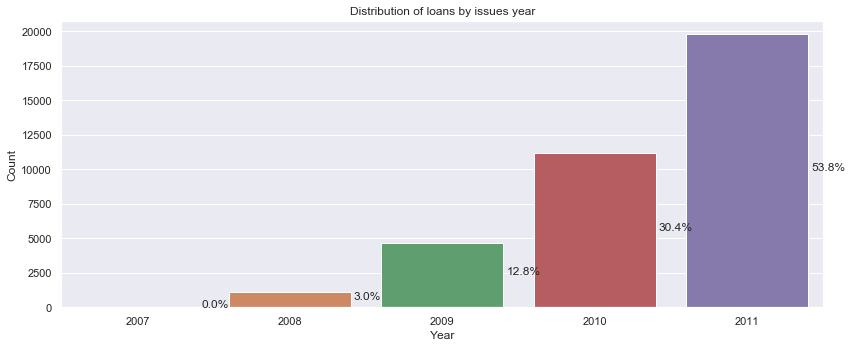

In [1993]:
univariate_analysis('loan_issue_year',
                    is_categorical=True,
                    title="Distribution of loans by issues year",
                    xlabel="Year",
                    ylabel="Count",
                    rotate_labels=False)

We can see that the most (almost half) loans are given in **2011** followed by **2010**

count   36735.0000
mean       13.3371
std         6.6496
min         0.0000
25%         8.2200
50%        13.4300
75%        18.5900
max        29.9900
Name: dti, dtype: float64


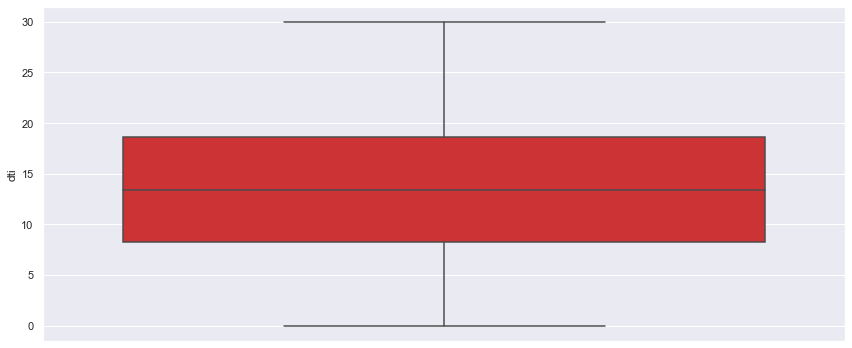

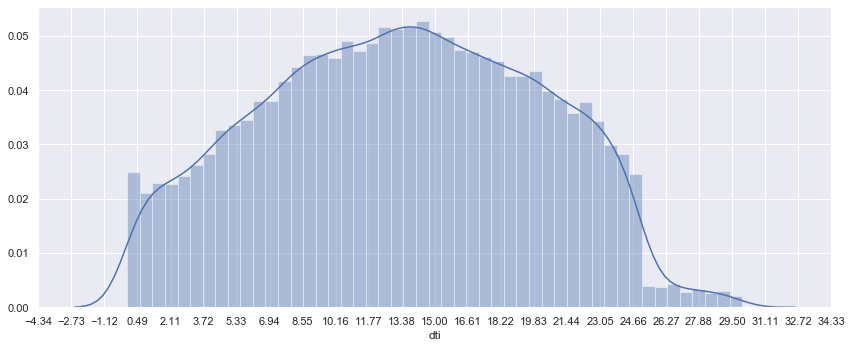

In [1994]:
univariate_analysis('dti')

As we can `dti` follows a normal distribution, however, to get better insights we will create new columns based on a range. More details for `dti` check here https://www.investopedia.com/terms/d/dti.asp

In [1995]:
add_categorical_column(loans,
                       [ 'low', 'medium', 'high'],
                       'dti', 'dti_category',
                       [0.0, 10.0, 20.0])

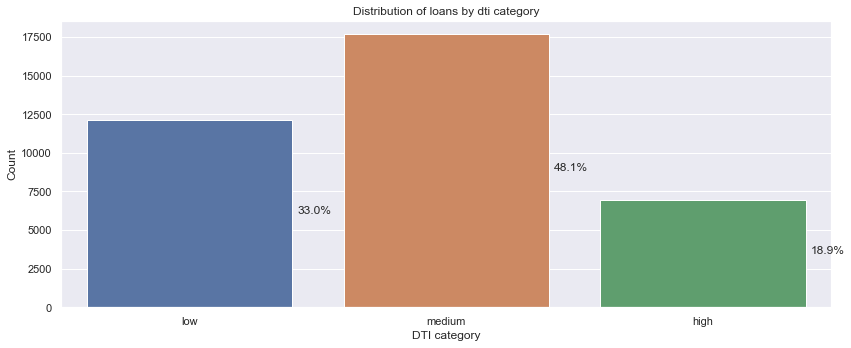

In [1996]:
univariate_analysis('dti_category',
                    is_categorical=True,
                    title="Distribution of loans by dti category",
                    xlabel="DTI category",
                    ylabel="Count",
                    rotate_labels=False)

As we can see, most of the borrowers have the `dti` ratio in the medium range.

count   36735.0000
mean        9.3058
std         4.3760
min         2.0000
25%         6.0000
50%         9.0000
75%        12.0000
max        44.0000
Name: open_acc, dtype: float64


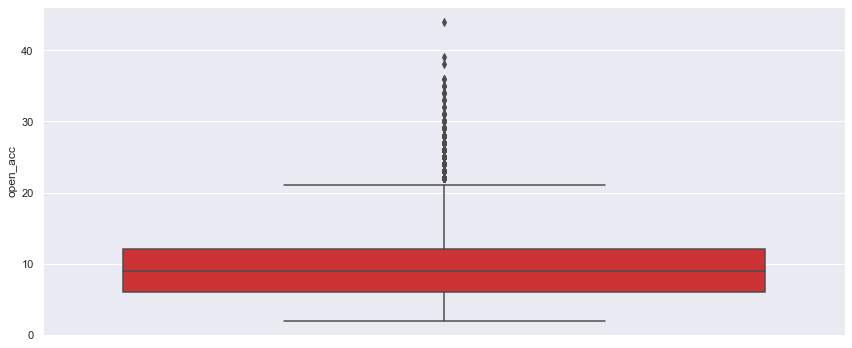

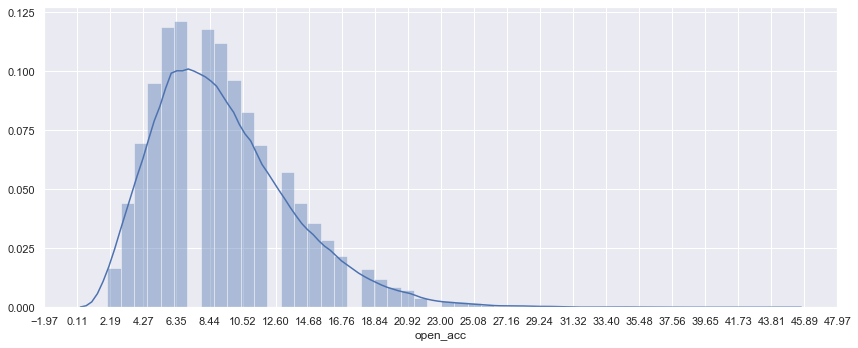

In [1997]:
univariate_analysis('open_acc')

As we can see here that there are some outliers here. We can mitigate their impact by creating a new variable which has a range.

In [1998]:
add_categorical_column(loans,
                       [ 'low', 'medium', 'high'],
                       'open_acc', 'open_accounts_category',
                       [0.0, 8.0, 16.0])

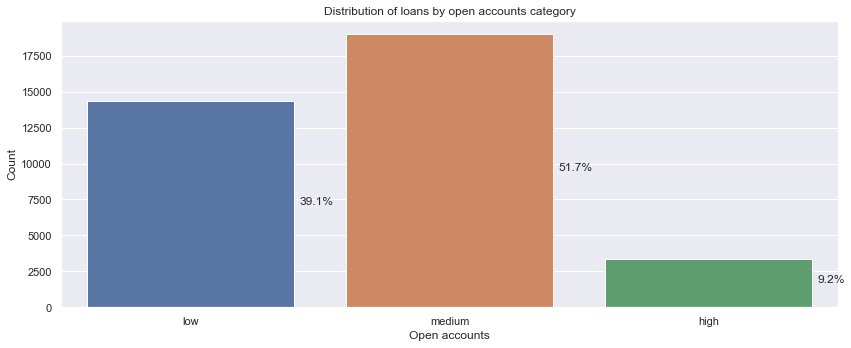

In [1999]:
univariate_analysis('open_accounts_category',
                    is_categorical=True,
                    title="Distribution of loans by open accounts category",
                    xlabel="Open accounts",
                    ylabel="Count",
                    rotate_labels=False)

We can see most borrowers have open accounts in the medium range.

count    36735.0000
mean     13384.8863
std      15856.3133
min          0.0000
25%       3734.5000
50%       8880.0000
75%      17035.5000
max     149588.0000
Name: revol_bal, dtype: float64


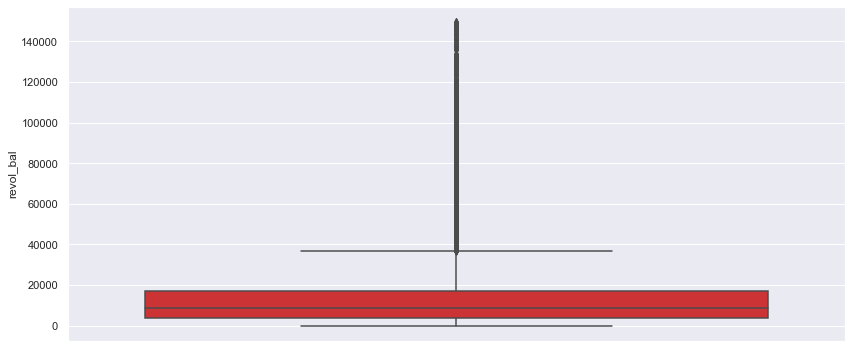

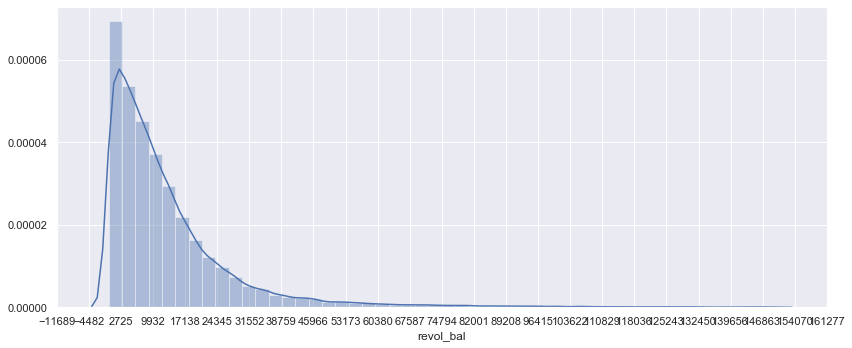

In [2000]:
univariate_analysis('revol_bal')

As we can revol_bal has some outliers, we will create a new column to mitigate this.

In [2001]:
add_categorical_column(loans,
                       [ 'low', 'medium', 'high'],
                       'revol_bal', 'revol_bal_category',
                       [0.0, 8000.0, 16000.0])

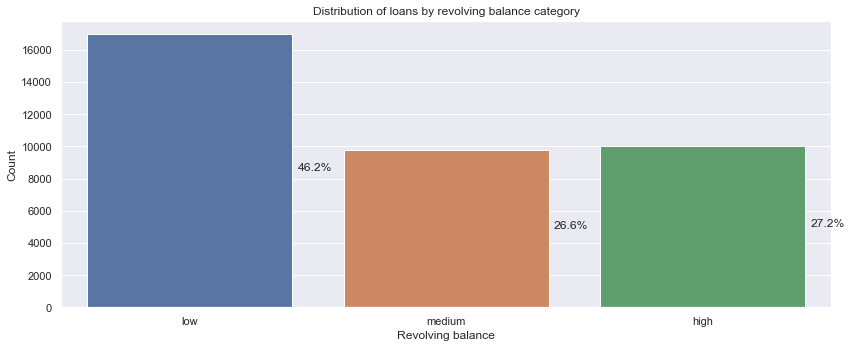

In [2002]:
univariate_analysis('revol_bal_category',
                    is_categorical=True,
                    title="Distribution of loans by revolving balance category",
                    xlabel="Revolving balance",
                    ylabel="Count",
                    rotate_labels=False)

We can see that most of the borrowers have low revolving balance.

In [2003]:
loans['revol_util'] = loans['revol_util'].str.replace('%',"").astype(float)

count   36735.0000
mean       48.9918
std        28.3137
min         0.0000
25%        25.6000
50%        49.5000
75%        72.5000
max        99.9000
Name: revol_util, dtype: float64


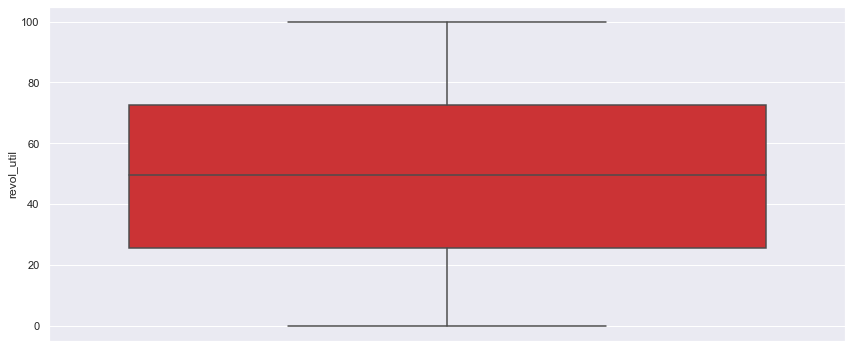

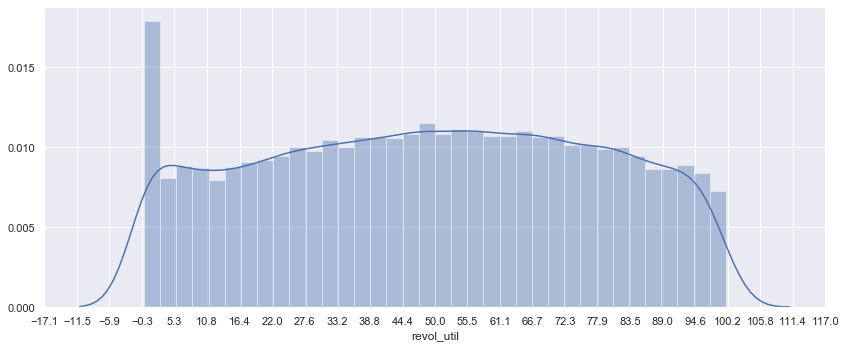

In [2004]:
univariate_analysis('revol_util')

As we can `revol_util` follows a normal distribution, however, to get better insights we will create new columns based on a range. More details for `revol_util` check here https://www.investopedia.com/terms/c/credit-utilization-rate.asp

In [2005]:
add_categorical_column(loans,
                       [ 'low', 'medium', 'high'],
                       'revol_util', 'revol_util_category',
                       [0.0, 30.0, 60.0])

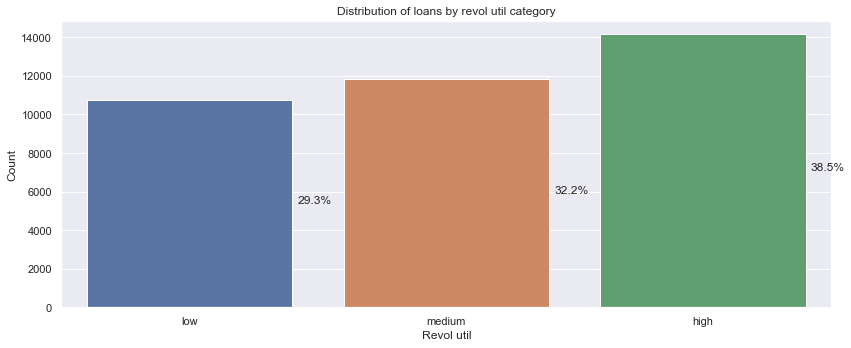

In [2006]:
univariate_analysis('revol_util_category',
                    is_categorical=True,
                    title="Distribution of loans by revol util category",
                    xlabel="Revol util",
                    ylabel="Count",
                    rotate_labels=False)

We can see almost 38% borrowers have high revol util (Credit Utilization Ratio)

count   36735.0000
mean      324.9947
std       208.8390
min        16.0800
25%       167.7300
50%       280.2800
75%       429.4500
max      1305.1900
Name: installment, dtype: float64


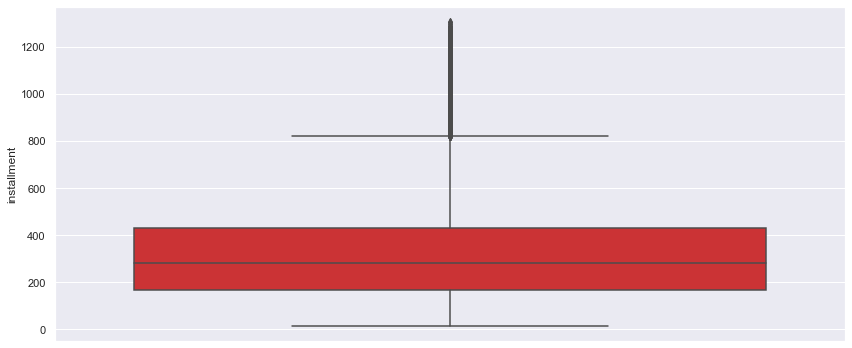

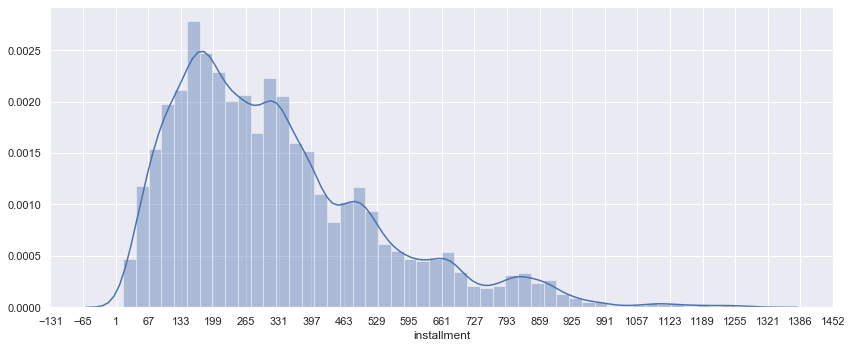

In [2007]:
univariate_analysis('installment')

There are some outliers, to mitigate this we can create new category.

In [2008]:
add_categorical_column(loans,
                       [ 'low', 'medium', 'high'],
                       'installment', 'installment_category',
                       [0.0, 200.0, 400.0])

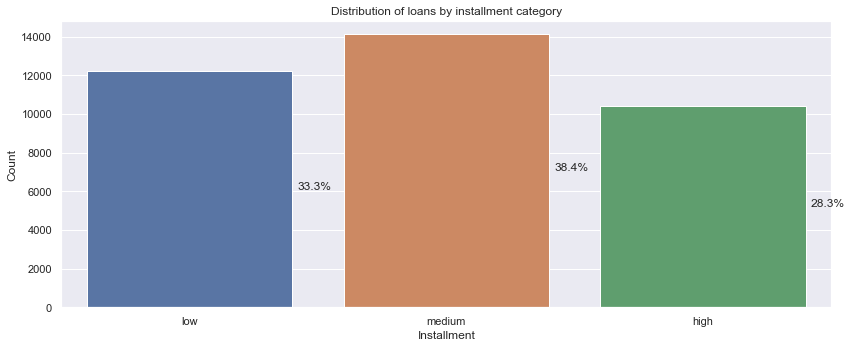

In [2009]:
univariate_analysis('installment_category',
                    is_categorical=True,
                    title="Distribution of loans by installment category",
                    xlabel="Installment",
                    ylabel="Count",
                    rotate_labels=False)

We can see most of the loans have medium installments.

# Segmented univariate analysis

We can analyze the income for records with grade as `B`.

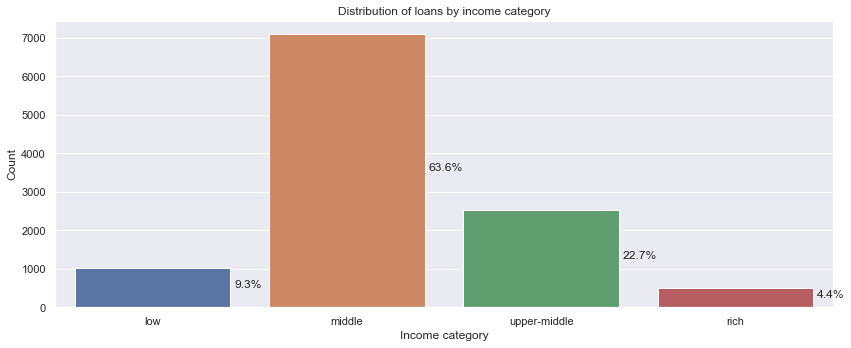

In [2010]:
univariate_analysis('income_category',
                    is_categorical=True,
                    title="Distribution of loans by income category",
                    xlabel="Income category",
                    ylabel="Count",
                    rotate_labels=False,df=loans[loans['grade']=='B'][['income_category']])

We can see that middle class income borrowers constitute the most in the loans with grade `B`

We will analyze employee experience for short term loans 

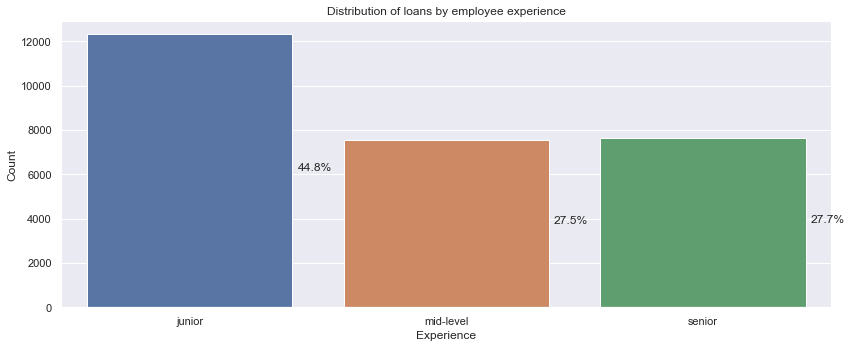

In [2011]:
univariate_analysis('emp_exp',
                    is_categorical=True,
                    title="Distribution of loans by employee experience",
                    xlabel="Experience",
                    ylabel="Count",
                    rotate_labels=False,df=loans[loans['term']=='36 months'][['emp_exp']])

We will analyze employee experience for long term loans 

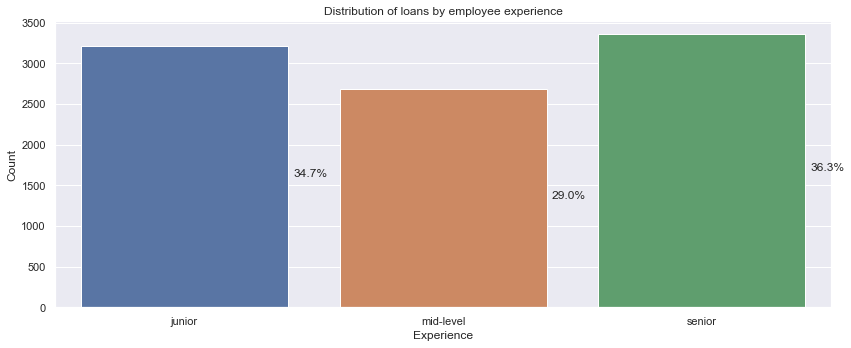

In [2012]:
univariate_analysis('emp_exp',
                    is_categorical=True,
                    title="Distribution of loans by employee experience",
                    xlabel="Experience",
                    ylabel="Count",
                    rotate_labels=False,df=loans[loans['term']=='60 months'][['emp_exp']])

We will analyze defaulted short term loans. 

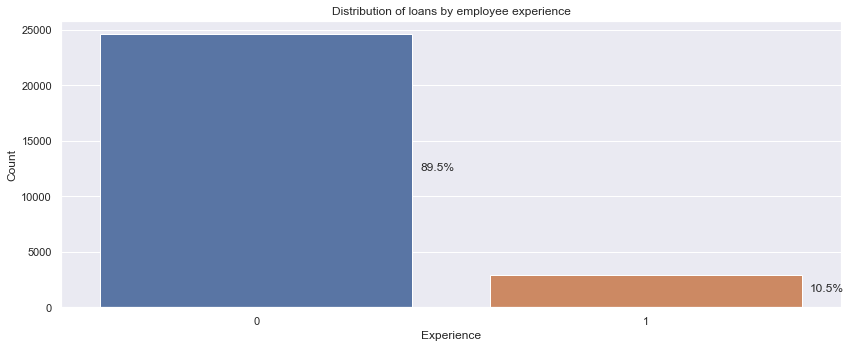

In [2013]:
univariate_analysis('loan_defaulted',
                    is_categorical=True,
                    title="Distribution of loans by employee experience",
                    xlabel="Experience",
                    ylabel="Count",
                    rotate_labels=False,
                    df=loans[loans['term'] == '36 months'][['loan_defaulted']])

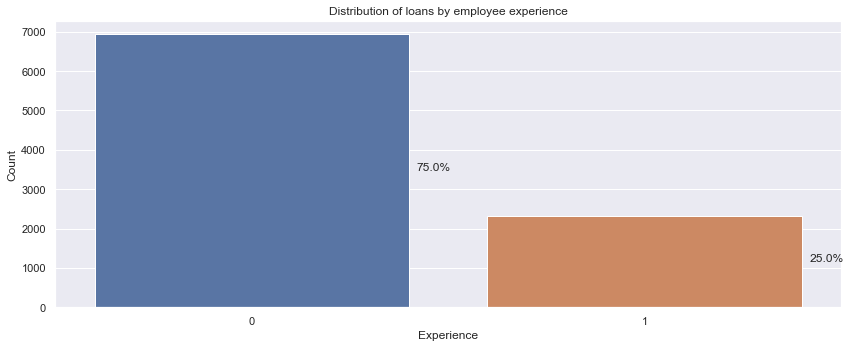

In [2014]:
univariate_analysis('loan_defaulted',
                    is_categorical=True,
                    title="Distribution of loans by employee experience",
                    xlabel="Experience",
                    ylabel="Count",
                    rotate_labels=False,
                    df=loans[loans['term'] == '60 months'][['loan_defaulted']])

We can see that long term loans are the most defaulted ones.

# Bivariate analysis

count         36735
unique            2
top       36 months
freq          27496
Name: term, dtype: object
mode:  0    36 months
dtype: object
36 months    27496
60 months     9239
Name: term, dtype: int64


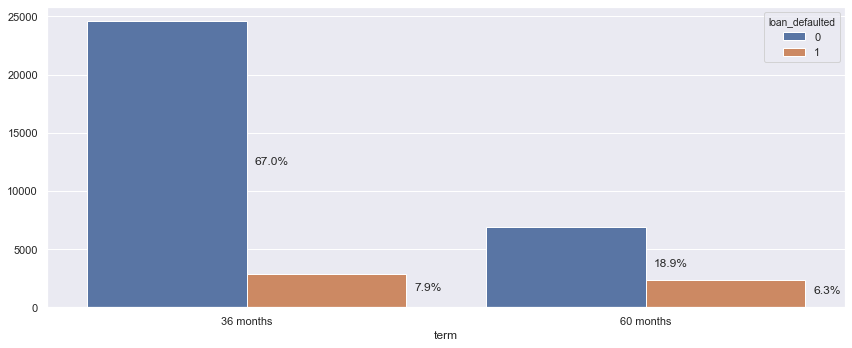

In [2015]:
c_palette = ['tab:green', 'tab:red']
categorical_summarized(loans, x = 'term', hue='loan_defaulted', palette=c_palette)

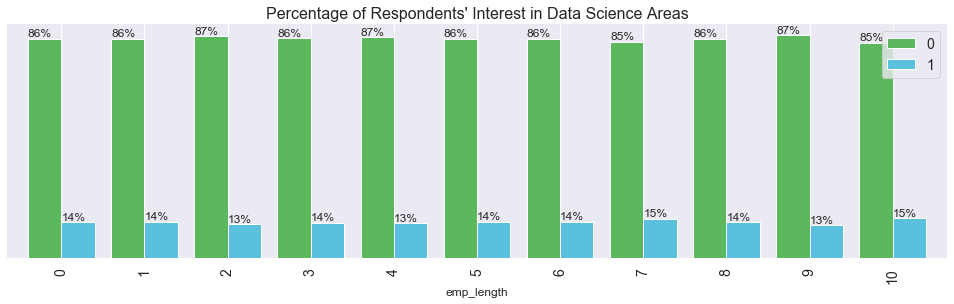

In [2016]:
colors_list = ['#5cb85c','#5bc0de']
test = loans[['emp_length','loan_defaulted']]
test = pd.crosstab(test.emp_length, test.loan_defaulted, margins=False)

# Change this line to plot percentages instead of absolute values
ax = (test.div(test.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,color = colors_list,edgecolor=None)
plt.legend(labels=test.columns,fontsize= 14)
plt.title("Percentage of Respondents' Interest in Data Science Areas",fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

count     36735
unique        7
top           B
freq      11136
Name: grade, dtype: object
mode:  0    B
dtype: object
B    11136
A     9512
C     7451
D     4838
E     2567
F      939
G      292
Name: grade, dtype: int64


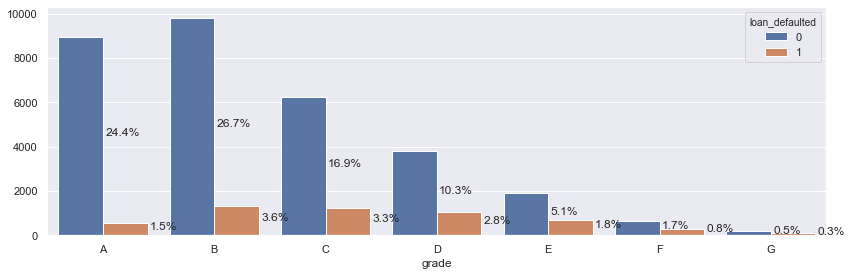

In [2017]:
categorical_summarized(loans, x = 'grade', hue='loan_defaulted', palette=c_palette, figsize=(12,4))

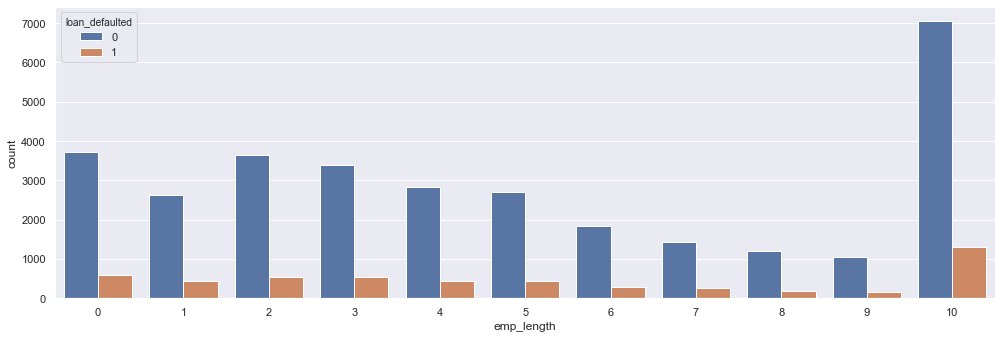

In [2018]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x='emp_length', hue='loan_defaulted', data=loans)

count   36735.0000
mean        4.9655
std         3.5524
min         0.0000
25%         2.0000
50%         4.0000
75%         9.0000
max        10.0000
Name: emp_length, dtype: float64
mode:  0    10
dtype: int64
10    8359
0     4322
2     4194
3     3940
4     3283
5     3147
1     3062
6     2132
7     1685
8     1405
9     1206
Name: emp_length, dtype: int64


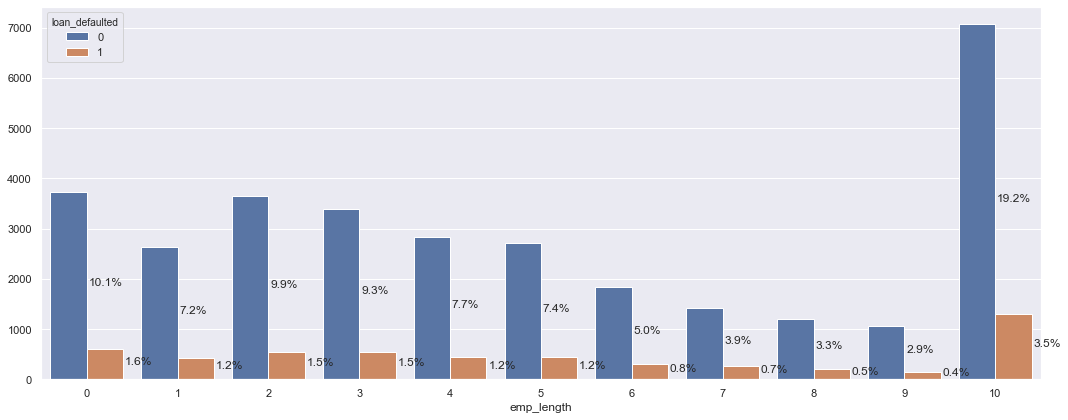

In [2019]:
categorical_summarized(loans, x = 'emp_length', hue='loan_defaulted', palette=c_palette, figsize=(15,6))

As, we can see `term` has two values, we can convert it into `category`.

In [2020]:
len(loans)

36735

In [2021]:
loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,funded_amnt_type,funded_amnt_inv_type,int_rate_slab,income_category,loan_issue_year,dti_category,open_accounts_category,revol_bal_category,revol_util_category,installment_category
0,5000,5000,4975.0000,36 months,10.6500,162.8700,B,B2,10,RENT,...,medium,low,medium,low,2011,high,low,medium,high,low
1,2500,2500,2500.0000,60 months,15.2700,59.8300,C,C4,0,RENT,...,low,low,high,middle,2011,low,low,low,low,low
2,2400,2400,2400.0000,36 months,15.9600,84.3300,C,C5,10,RENT,...,low,low,high,low,2011,low,low,low,high,low
3,10000,10000,10000.0000,36 months,13.4900,339.3100,C,C1,10,RENT,...,medium,medium,medium,middle,2011,high,medium,low,low,medium
5,5000,5000,5000.0000,36 months,7.9000,156.4600,A,A4,3,RENT,...,medium,medium,low,middle,2011,medium,medium,low,low,low


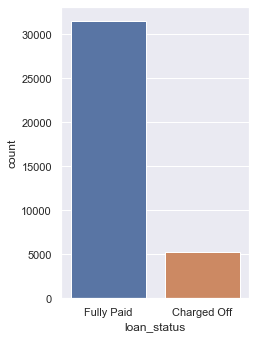

In [2022]:
sns.set(rc={'figure.figsize':(3,5)})
sns.countplot(x='loan_status',data=loans)

In [2023]:
loans['loan_status'].value_counts()

Fully Paid     31533
Charged Off     5202
Name: loan_status, dtype: int64

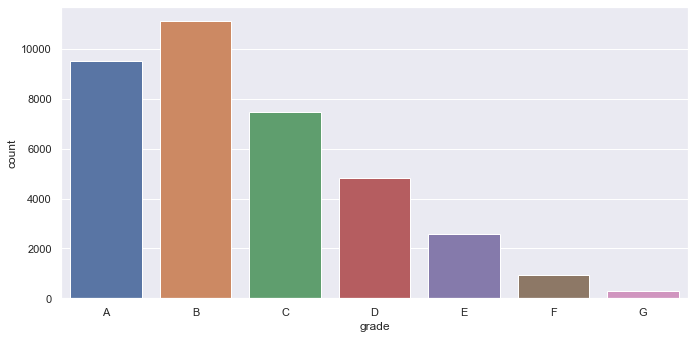

In [2024]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='grade',data=loans.sort_values(['grade']))

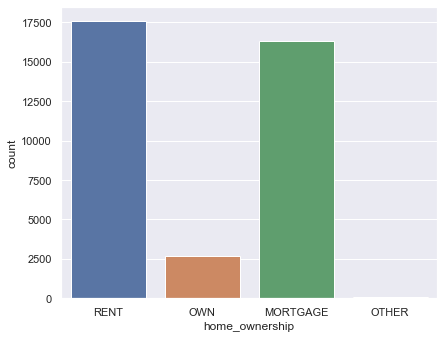

In [2025]:
sns.set(rc={'figure.figsize':(6,5)})
sns.countplot(x='home_ownership',data=loans)

Changing type of columns `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` and `tax_liens` from float to int

We can see `pub_rec_bankruptcies` has 3 values, which can be considered as Ordinal categorical variable

In [2026]:
loans['pub_rec_bankruptcies'] = loans['pub_rec_bankruptcies'].astype('category')

In [2027]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set()
sns.heatmap(loans_num.corr(method='spearman'), annot=True, fmt='.2f', linewidths=2)

sns.set()

NameError: name 'loans_num' is not defined

In [ ]:
#sns.pairplot(loans_num)

In [ ]:
loans['earliest_cr_line'].value_counts()